In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from IPython.core.interactiveshell import InteractiveShell 
InteractiveShell.ast_node_interactivity = "all"
from scipy.spatial import distance
import functools

In [2]:
df0 = pd.read_csv('c:/Users/gandh/dev/unv/smoed/NB/data/main_data.csv')
X = df0['nu']
Y = df0['E']

### Нормализация

In [3]:
X_norm = MinMaxScaler().fit_transform(df0)
df = pd.DataFrame(data=X_norm, columns=['nu','E'])
df.round(3).to_csv('data/df_norm.csv', index=False)

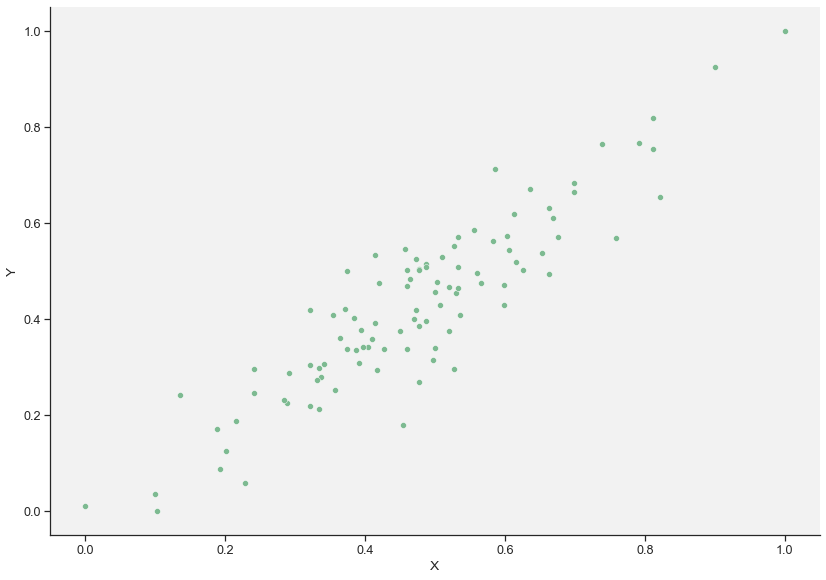

In [4]:
sns.set_theme(palette='crest', font_scale=1.15)
sns.set_style("ticks", {"axes.facecolor": ".95"})
ax = sns.relplot(data=df, x='nu', y='E', kind='scatter', height=8.27, aspect=11.7/8.27)
ax.set_axis_labels('X', 'Y')
plt.tight_layout()
plt.savefig('pics/1.png')

## Алгоритм

In [5]:
def sc_plots(data, center, R, step, itera):   
    ax = sns.relplot(data=data, x='nu', y='E', hue='кластер', kind='scatter', palette='flare',
                     alpha=0.9, height=8.27, aspect=11.7/8.27, legend=False)
    for j in [center]:
        plt.scatter(j[0],j[1], c='crimson', s=80)    
        
#     df_CN = df_CN.append({'x':center.values[0].round(4),
#                           'y':center.values[1].round(4),
#                           'N':data[data["кластер"]!=-1]["nu"].count()})    
    print(center.values[:2])
    print(data[data['кластер']!=-1]['nu'].count())

    circle = np.array([], dtype=np.float64)     
    for i in data[data['кластер']!=-1].values:       
        circle = np.append(circle, np.linalg.norm(i[:-1]-center.values[:2]))
    
#     plt.scatter(j[0], j[1], linewidths=1, facecolors='crimson', edgecolors='crimson', s=max(circle)*2*50000, alpha=0.1)
    
    ax.set_axis_labels('X', 'Y')
    ax.set(xlim=[-0.1,1.1], ylim=[-0.1,1.1])
    plt.tight_layout()
    plt.savefig(f'pics/{itera}_{step}.png')
    plt.show()

In [6]:
def Fs(data):
    curr_data = data.copy()
    cts = curr_data.groupby('кластер').mean()
    F1,F2,F3 = 0,0,0
    
    # F1 - сумма кв. расст. точек до центров соотв. кластеров
    for i in range(len(curr_data)):        
        dist_F1 = np.linalg.norm(curr_data.iloc[i,:-1].values-cts.values[curr_data.iloc[i,2]-1])
        F1 += dist_F1**2
        
    # F2 - сумма кв. расст. до всех точек соотв. кластеров    
    for i in range(1,len(cts)+1):
        coords = curr_data[curr_data['кластер']==i].iloc[:,:2].values
        dist_F2 = distance.cdist(coords, coords, 'euclidean')
        F2 += (np.triu(dist_F2,0)**2).sum()

    # F3 - сумма внутрикластерных дисперсий
    F3 = curr_data.groupby('кластер').var().values.sum(where=~np.isnan(curr_data.groupby('кластер').var().values), initial=0)
    
    return F1,F2,F3

In [7]:
def custFE(cur_data, R, itera, plots=1, max_iter=20): 
    cur_dist = np.array([], dtype=np.float64)
    data = cur_data.copy()
    coords = data.values

    # расстояние между объектами
    dist = distance.cdist(coords, coords, 'euclidean') 
    data['кластер'] = -1

    # сколько объектов с растоянием < R для каждого объекта
    for i in dist:
        cur_dist = np.append(cur_dist, len(i[np.where((i>=0) & (i<=R))])) 

    # индекс центра
    center_ind = np.argmax(cur_dist) 
    # индексы объектов с расстоянием < R до центра
    cluster_ind = np.where((dist[np.argmax(cur_dist)]>=0) &
                           (dist[np.argmax(cur_dist)]<=R))
    data.iloc[cluster_ind[0],2] = itera
    data.iloc[center_ind,2] = itera
    if plots == 1:
        sc_plots(data, data.iloc[center_ind], R, 1, itera)
    cur_center = data.iloc[center_ind]
    
    for it in range(max_iter):
        distl = np.array([], dtype=np.float64)
        # новый центр тяжетси
        center = data[data['кластер']==itera].mean()
        data['кластер'] = -1

        # расстояния до нового центра
        for i in data.iloc[:,:2].values:
            distl = np.append(distl, np.linalg.norm(center[:-1].values-i))
        cluster_ind = np.where((distl>=0) & (distl<=R))

        data.iloc[cluster_ind[0],2] = itera

        if functools.reduce(lambda x, y : x and y, map(lambda p, q: p == q,center.values,cur_center.values), True):
            break
        if plots == 1:
            sc_plots(data, center, R, it+2, itera)
        cur_center = center

    # график
    if plots == 0:
        sc_plots(data, center, R, 'последний', itera)
    
    return data[data['кластер']==-1], data, np.array(center.values[:2])

## Основа

In [8]:
coords = df.iloc[:,:2].values
dist = np.triu(distance.cdist(coords, coords, 'euclidean'), 0)
rmin = np.amin(dist, where=dist!=0, initial=10)
rmax = np.amax(dist)
rmin.round(5), rmax.round(5)

(0.00181, 1.40658)

In [109]:
upd_df = df.copy()
it = 1
radius = 0.37
df['кластер'] = -1
ctrs = np.array([], dtype=np.float64)

[0.47354889 0.42919941]
85


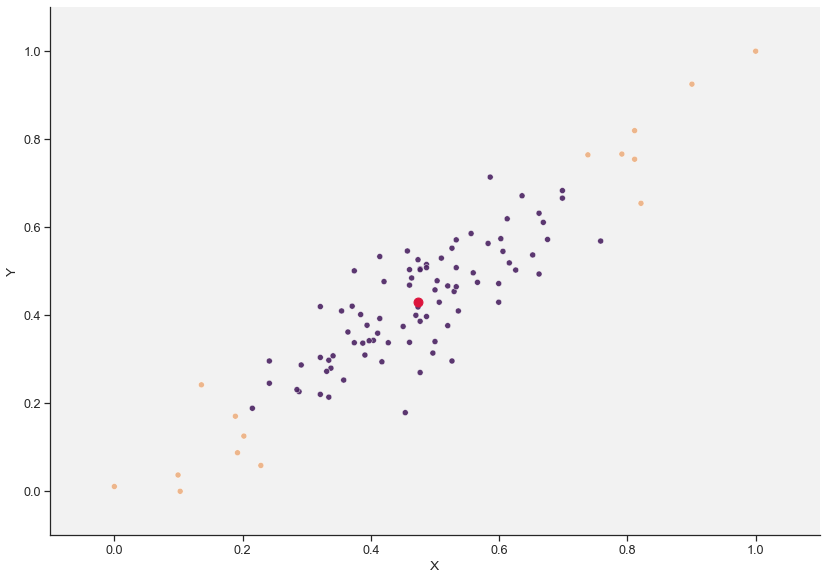

[0.14362583 0.09149368]
8


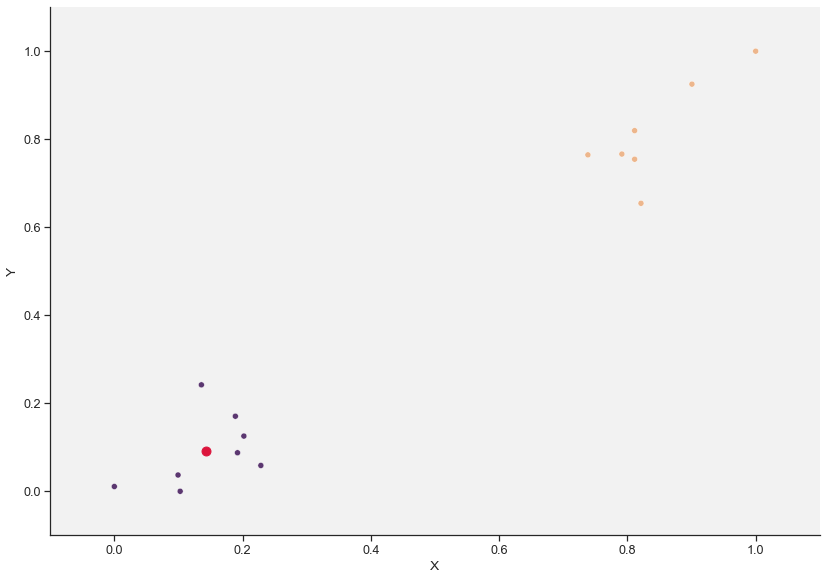

[0.83916746 0.8120165 ]
7


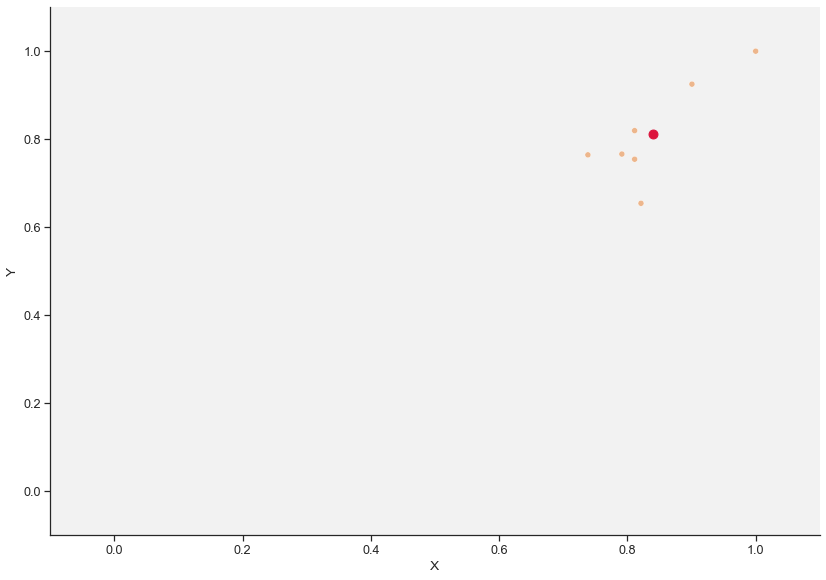

In [110]:
while len(upd_df):
    upd_df, main, ctr = custFE(upd_df, radius, it, 0)
    ctrs = np.append(ctrs, [ctr])
    it += 1    
    df.loc[main[main['кластер']!=-1].index, :] = main.loc[main[main['кластер']!=-1].index, :]
df.to_csv('data/result.csv', index=False)

In [111]:
F1, F2, F3 = Fs(df)
F1.round(5), F2.round(5), F3.round(5)

(2.70377, 213.29834, 0.06304)

### Финальное разбиение

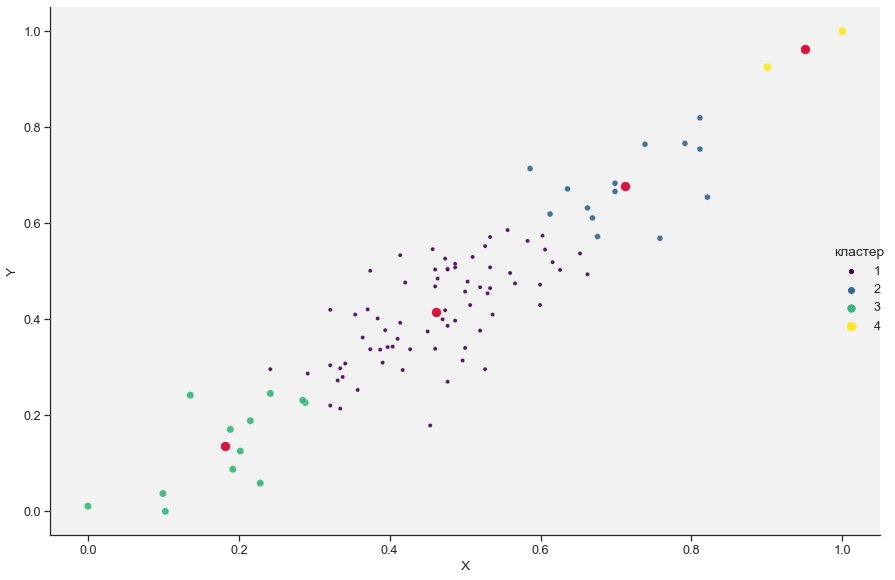

In [12]:
ax = sns.relplot(data=df, x='nu', y='E', hue='кластер', kind='scatter', palette='viridis', alpha=0.9,
                 size='кластер', height=8.27, aspect=11.7/8.27)
ctrs = ctrs.reshape((-1,2))
for i in ctrs:
    plt.scatter(i[0], i[1], c='crimson', s=70)
ax.set_axis_labels('X', 'Y')
plt.tight_layout()
plt.savefig('pics/result.png')
plt.show()